Shape of the dataset: (50410, 8)
   Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3           3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
4           4 2019-01-01 00:04:33  Austria     124        0  Simplecard   

   3D_secured    card  
0           0    Visa  
1           0    Visa  
2           1  Diners  
3           1  Diners  
4           0  Diners  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 n

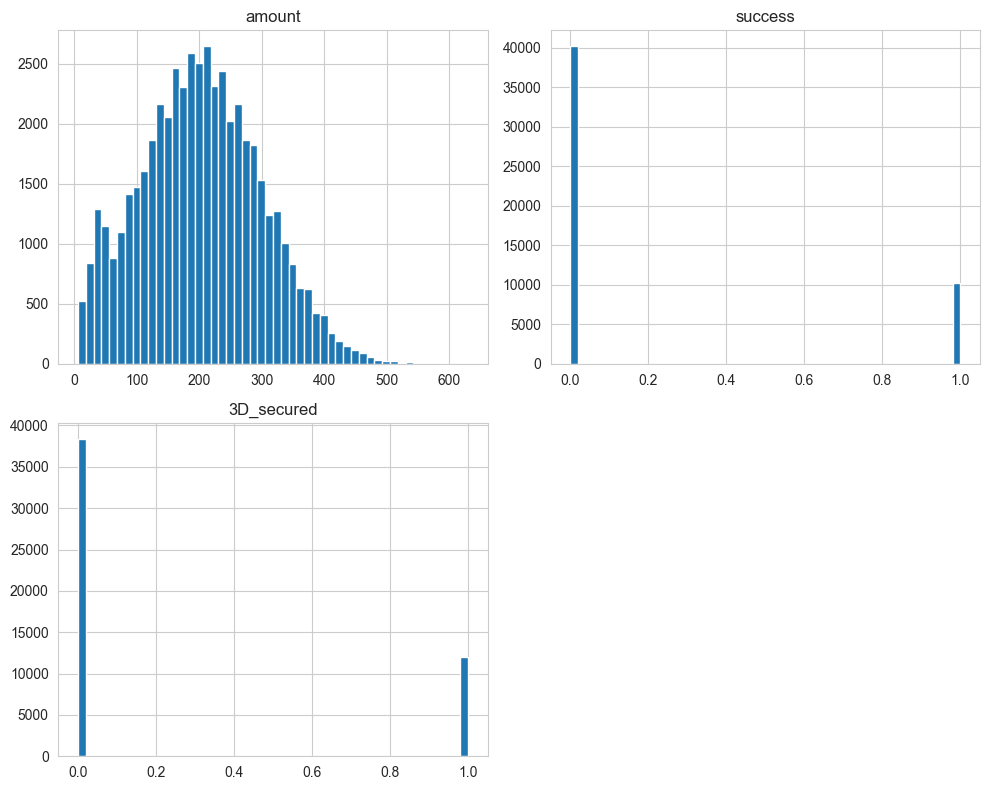

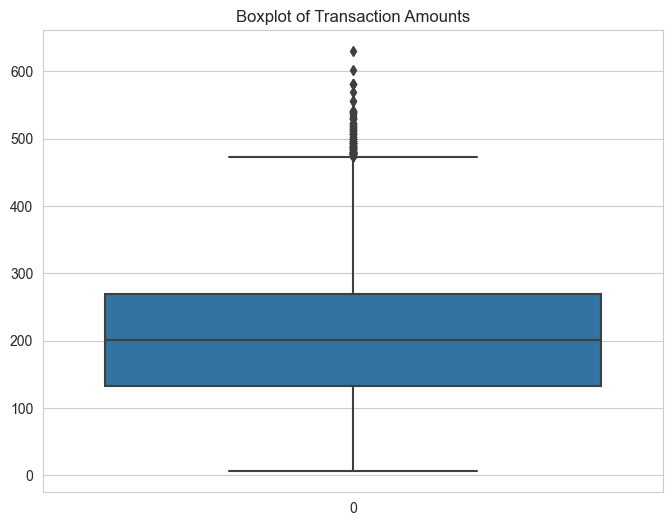

In [21]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# a. Load the dataset
data = pd.read_excel("PSP_Jan_Feb_2019.xlsx")

# b. High-level overview of structure and contents
print("Shape of the dataset:", data.shape)  # Displaying the shape
print(data.head())
print(data.info())

# c. Basic statistics for numerical columns
numerical_stats = data[["amount", "success", "3D_secured"]].describe()
print(numerical_stats)

# d. Basic statistics for categorical columns
categorical_stats = data[["country", "PSP", "card"]].describe(include="object")
print(categorical_stats)

# e. Value counts for categorical columns
print("\nValue counts for 'country':\n", data["country"].value_counts())
print("\nValue counts for 'PSP':\n", data["PSP"].value_counts())
print("\nValue counts for 'card':\n", data["card"].value_counts())

# f. Visualizing the distribution of numerical columns
sns.set_style("whitegrid")
data[["amount", "success", "3D_secured"]].hist(figsize=(10, 8), bins=50)
plt.tight_layout()
plt.show()

# g. Identifying potential anomalies for 'amount' column
plt.figure(figsize=(8, 6))
sns.boxplot(data["amount"])
plt.title("Boxplot of Transaction Amounts")
plt.show()


In [22]:
# Drop the unnecessary first column
data.drop(columns=["Unnamed: 0"], inplace=True)

# 1. Handle Missing or Erroneous Data
# Confirming no missing values
missing_values_check = data.isnull().sum()

# 2. Convert Categorical Variables
# Using one-hot encoding for categorical columns to convert them into a numerical format
df = pd.get_dummies(data, columns=["country", "PSP", "card"])
# 3. Address Potential Outliers
# Checking for outliers in the 'amount' column using the IQR method
Q1 = df["amount"].quantile(0.25)
Q3 = df["amount"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying outliers
outliers = df[(df["amount"] < lower_bound) | (df["amount"] > upper_bound)]
percentage_outliers = len(outliers) / len(df) * 100

print("Missing Values Check:\n", missing_values_check)
print("\nProcessed Data (First 5 Rows):\n", df.head())
print("\nPercentage of Transactions Considered Outliers:", percentage_outliers, "%")

Missing Values Check:
 tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

Processed Data (First 5 Rows):
                  tmsp  amount  success  3D_secured  country_Austria  \
0 2019-01-01 00:01:11      89        0           0                0   
1 2019-01-01 00:01:17      89        1           0                0   
2 2019-01-01 00:02:49     238        0           1                0   
3 2019-01-01 00:03:13     238        1           1                0   
4 2019-01-01 00:04:33     124        0           0                1   

   country_Germany  country_Switzerland  PSP_Goldcard  PSP_Moneycard  \
0                1                    0             0              0   
1                1                    0             0              0   
2                1                    0             0              0   
3                1                    0             0              0   
4                0              

In [19]:
# Required Libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Temporal Features
df["hour"] = df["tmsp"].dt.hour
df["day"] = df["tmsp"].dt.day
df["weekday"] = df["tmsp"].dt.weekday
df["week"] = df["tmsp"].dt.isocalendar().week
bins = [0, 6, 12, 18, 24]
labels = ["Night", "Morning", "Afternoon", "Evening"]
df["time_of_day"] = pd.cut(df["hour"], bins=bins, labels=labels, right=False)

# Recognizing multiple payment attempts
df["multiple_attempts"] = 0
for i in range(1, len(df)):
    time_difference = (df.loc[i, "tmsp"] - df.loc[i - 1, "tmsp"]).seconds
    if (
        (time_difference <= 60)
        and (df.loc[i, "amount"] == df.loc[i - 1, "amount"])
        and (df.loc[i, "country_Austria"] == df.loc[i - 1, "country_Austria"])
        and (df.loc[i, "country_Germany"] == df.loc[i - 1, "country_Germany"])
        and (df.loc[i, "country_Switzerland"] == df.loc[i - 1, "country_Switzerland"])
    ):
        df.loc[i, "multiple_attempts"] = 1

# 2. Transaction Retry
df["retry_count"] = df.groupby(
    ["country_Austria", "country_Germany", "country_Switzerland", "amount"]
)["multiple_attempts"].cumsum()

# 3. Interaction Features
df["country_PSP_UK_Card"] = df["country_Germany"] * df["PSP_UK_Card"]
df["country_PSP_Moneycard"] = df["country_Germany"] * df["PSP_Moneycard"]
df["country_PSP_Simplecard"] = df["country_Germany"] * df["PSP_Simplecard"]
df["card_PSP_UK_Card"] = df["card_Master"] * df["PSP_UK_Card"]
df["card_PSP_Moneycard"] = df["card_Master"] * df["PSP_Moneycard"]

# 4. Aggregated Features
psp_success_rates = df.groupby("PSP_UK_Card")["success"].mean().to_dict()
df["PSP_UK_Card_success_rate"] = df["PSP_UK_Card"].map(psp_success_rates)
card_success_rates = df.groupby("card_Master")["success"].mean().to_dict()
df["card_Master_success_rate"] = df["card_Master"].map(card_success_rates)

# 5. Amount Binning
bins = [0, 50, 200, 400, 700]
labels = ["Low", "Medium", "High", "Very High"]
df["amount_category"] = pd.cut(df["amount"], bins=bins, labels=labels)

# 6. 3D Secure Interaction
df["PSP_UK_Card_3D_secured"] = df["PSP_UK_Card"] * df["3D_secured"]
df["PSP_Moneycard_3D_secured"] = df["PSP_Moneycard"] * df["3D_secured"]
df["PSP_Simplecard_3D_secured"] = df["PSP_Simplecard"] * df["3D_secured"]

# 7. Normalization
scaler = StandardScaler()
df["amount_scaled"] = scaler.fit_transform(df[["amount"]])


In [20]:
pd.set_option("display.max_columns", 30)

df.head(10)

,tmsp,amount,success,3D_secured,country_Germany,country_Switzerland,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,card_Master,card_Visa,hour,day,weekday,week,time_of_day,multiple_attempts,retry_count,country_PSP_UK_Card,country_PSP_Moneycard,country_PSP_Simplecard,card_PSP_UK_Card,card_PSP_Moneycard,PSP_UK_Card_success_rate,card_Master_success_rate,amount_category,PSP_UK_Card_3D_secured,PSP_Moneycard_3D_secured,PSP_Simplecard_3D_secured,amount_scaled
0,2019-01-01 00:01:11,89,0,0,1,0,0,0,1,0,1,0,1,1,1,Night,0,0,1,0,0,0,0,0.194338,0.215107,Medium,0,0,0,-1.177846
1,2019-01-01 00:01:17,89,1,0,1,0,0,0,1,0,1,0,1,1,1,Night,1,1,1,0,0,0,0,0.194338,0.215107,Medium,0,0,0,-1.177846
2,2019-01-01 00:02:49,238,0,1,1,0,0,0,1,0,0,0,1,1,1,Night,0,0,1,0,0,0,0,0.194338,0.215107,High,1,0,0,0.369823
3,2019-01-01 00:03:13,238,1,1,1,0,0,0,1,0,0,0,1,1,1,Night,1,1,1,0,0,0,0,0.194338,0.215107,High,1,0,0,0.369823
4,2019-01-01 00:04:33,124,0,0,0,0,0,1,0,0,0,0,1,1,1,Night,0,0,0,0,0,0,0,0.212350,0.215107,Medium,0,0,0,-0.814300
5,2019-01-01 00:06:41,282,0,0,0,1,0,0,1,1,0,0,1,1,1,Night,0,0,0,0,0,1,0,0.194338,0.193883,High,0,0,0,0.826853
6,2019-01-01 00:07:19,282,0,0,0,1,0,1,0,1,0,0,1,1,1,Night,1,1,0,0,0,0,0,0.212350,0.193883,High,0,0,0,0.826853
7,2019-01-01 00:08:46,117,1,0,1,0,0,0,1,1,0,0,1,1,1,Night,0,0,1,0,0,1,0,0.194338,0.193883,Medium,0,0,0,-0.887009
8,2019-01-01 00:09:56,174,0,0,0,1,0,1,0,0,1,0,1,1,1,Night,0,0,0,0,0,0,0,0.212350,0.215107,Medium,0,0,0,-0.294948
9,2019-01-01 00:10:49,174,0,0,0,1,0,1,0,0,1,0,1,1,1,Night,1,1,0,0,0,0,0,0.212350,0.215107,Medium,0,0,0,-0.294948
